<a href="https://colab.research.google.com/github/pyijiezhang/cold-posteriors-and-pacbayes/blob/main/results/bnn_classification_mfvi/results_vi_nn_classification_andres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pickle

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files


In [4]:
def get_metrics(results):

    metrics_dict = {}

    for seed in results.keys():

        result_seed = results[seed]
        cpe_weights = list(result_seed.keys())
        # cpe_weights.remove("setting")

        _, n_post_samples = result_seed[cpe_weights[0]][0].shape

        metrics_dict[seed] = {}

        metrics_dict[seed]["nll_gibbs_train"] = []
        metrics_dict[seed]["nll_gibbs_test"] = []
        metrics_dict[seed]["nll_bayes_train"] = []
        metrics_dict[seed]["nll_bayes_test"] = []

        metrics_dict[seed]["err_gibbs_train"] = []
        metrics_dict[seed]["err_gibbs_test"] = []
        metrics_dict[seed]["err_bayes_train"] = []
        metrics_dict[seed]["err_bayes_test"] = []

        # metrics_dict[seed]["grad_nll_gibbs"]=[]

        for cpe_weight in cpe_weights:

            log_p_train = torch.tensor(result_seed[cpe_weight][0])
            log_p_test = torch.tensor(result_seed[cpe_weight][1])

            metrics_dict[seed]["nll_gibbs_train"].append(-log_p_train.mean().item())
            metrics_dict[seed]["nll_gibbs_test"].append(-log_p_test.mean().item())

            bayes_loss_train = (
                (
                    torch.log(torch.tensor(n_post_samples))
                    - torch.logsumexp(log_p_train, 1)
                )
                .mean()
                .item()
            )
            metrics_dict[seed]["nll_bayes_train"].append(bayes_loss_train)
            bayes_loss_test = (
                (
                    torch.log(torch.tensor(n_post_samples))
                    - torch.logsumexp(log_p_test, 1)
                )
                .mean()
                .item()
            )
            metrics_dict[seed]["nll_bayes_test"].append(bayes_loss_test)

            # grad_expected_gibbs = (
            #         -n_train
            #         * (
            #             (log_p_train.mean(0) * log_p_test.mean(0)).mean()
            #             - log_p_test.mean() * log_p_train.mean()
            #         ).item()
            #     )
            # metrics_dict[seed]["grad_nll_gibbs"].append(grad_expected_gibbs)

            metrics_dict[seed]["err_gibbs_train"].append(
                1 - np.array(result_seed[cpe_weight][2])[:, 1].mean()
            )
            metrics_dict[seed]["err_gibbs_test"].append(
                1 - np.array(result_seed[cpe_weight][3])[:, 1].mean()
            )
            metrics_dict[seed]["err_bayes_train"].append(
                1 - np.array(result_seed[cpe_weight][4])[:, 1].mean()
            )
            metrics_dict[seed]["err_bayes_test"].append(
                1 - np.array(result_seed[cpe_weight][5])[:, 1].mean()
            )

    return metrics_dict


# in-between seeds

In [5]:
# dir_prefix = f"./between seeds/{setting_i}/"
# if not os.path.exists(dir_prefix):
#     os.makedirs(dir_prefix)


In [6]:
# name_metrics=list(metrics[seeds[0]].keys())
# for name_metric in name_metrics:
#     save_name=f"{name_metric}"
#     plt.figure()
#     plt.title(save_name)
#     for seed in seeds:
#         plt.plot(np.arange(0,len(cpe_weights),1),metrics[seed][name_metric], marker="o", label=f"{seed}")

#     plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
#     plt.legend()
#     plt.xlabel("lambda, log scale")
#     plt.ylabel(name_metric)
#     plt.ylim(0,0.1)
#     # plt.savefig(f"./{dir_prefix}/{save_name}.png", dpi=300)
#     plt.show()


# main plots
## prior

In [7]:
dir='./cold-posteriors-and-pacbayes/results/bnn_classification_mfvi/results_big_lenet_batchsize_100_epoch_100'

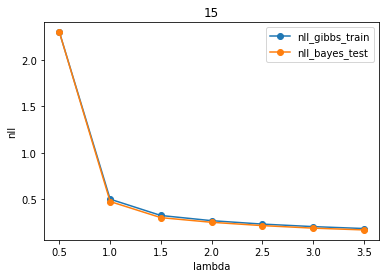

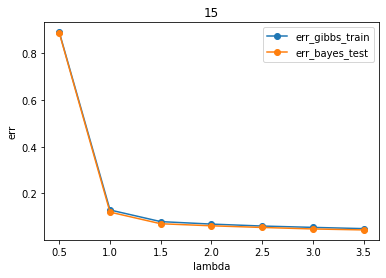

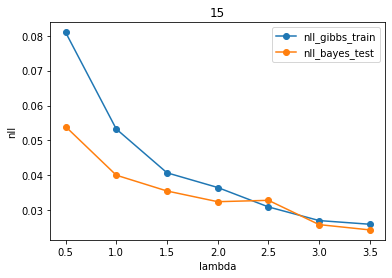

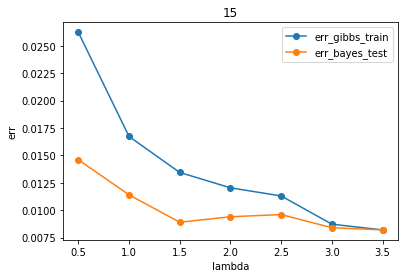

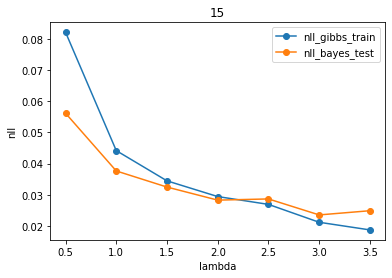

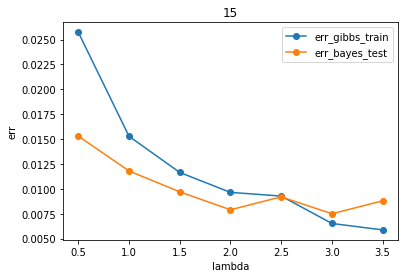

In [8]:
all_metrics_priors = {}
for prior_scale in [0.01, 0.1, 1.0]:
    setting_i = f"{dir}/prior_scale_{prior_scale}_label_noise_0.0_smooth_softmax_1.0_data_augmentation_False"

    with open(f"{setting_i}.pickle", "rb") as handle:
        results = pickle.load(handle)
    metrics = get_metrics(results)
    seeds = list(results.keys())
    cpe_weights = list(results[seeds[0]].keys())
    # cpe_weights.remove("setting")

    all_metrics_priors[prior_scale] = metrics

    dir_prefix = f"./main/{setting_i}/"
    if not os.path.exists(dir_prefix):
        os.makedirs(dir_prefix)

    name_metrics = ["nll", "err"]
    for metric in name_metrics:
        for seed in seeds:
            save_name = f"main_{metric}_{seed}"
            plt.title(f"{seed}")
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_gibbs_train"],
                marker="o",
                label=f"{metric}_gibbs_train",
            )
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_bayes_test"],
                marker="o",
                label=f"{metric}_bayes_test",
            )
            # plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
            plt.xticks(np.arange(0, len(cpe_weights), 1), cpe_weights)
            plt.xlabel("lambda")
            plt.ylabel(f"{metric}")
            # plt.ylim(0,0.5)
            plt.legend()
            plt.savefig(f"{dir_prefix}/{save_name}.png", dpi=300)
            plt.show()


In [9]:
name_metric = "err_bayes_test"
name_seed = 15
df = pd.DataFrame()
for prior_scale in [0.01, 0.1, 1.0]:
    this_df = pd.DataFrame.from_dict(all_metrics_priors[prior_scale][name_seed])[name_metric]
    this_df.rename(prior_scale, inplace=True)
    df = pd.concat([df, this_df], axis=1)
df.index = list(np.linspace(0.5, 3.5, 7))


In [10]:
df


,0.01,0.10,1.00
0.5,0.8865,0.0146,0.0153
1.0,0.1200,0.0114,0.0118
1.5,0.0703,0.0089,0.0097
2.0,0.0615,0.0094,0.0079
2.5,0.0544,0.0096,0.0092
3.0,0.0480,0.0084,0.0075
3.5,0.0439,0.0082,0.0088


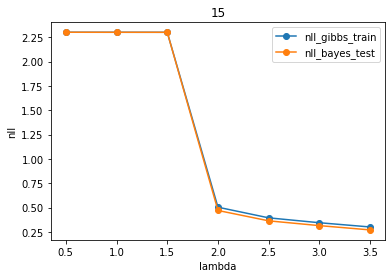

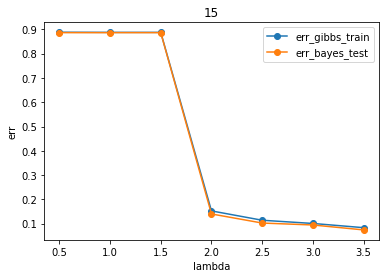

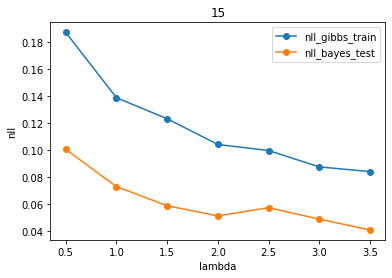

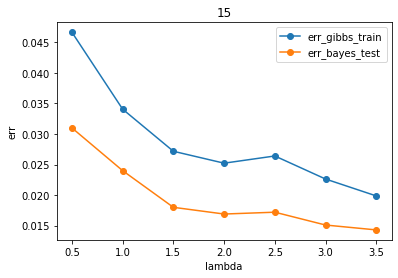

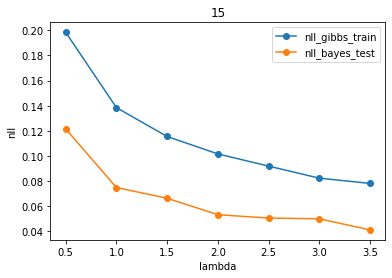

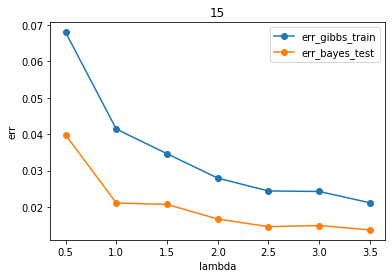

In [11]:
all_metrics_priors_aug = {}
for prior_scale in [0.01, 0.1, 1.0]:
    setting_i = f"{dir}/prior_scale_{prior_scale}_label_noise_0.0_smooth_softmax_1.0_data_augmentation_True"

    with open(f"{setting_i}.pickle", "rb") as handle:
        results = pickle.load(handle)
    metrics = get_metrics(results)
    seeds = list(results.keys())
    cpe_weights = list(results[seeds[0]].keys())
    # cpe_weights.remove("setting")

    all_metrics_priors_aug[prior_scale] = metrics

    dir_prefix = f"./main/{setting_i}/"
    if not os.path.exists(dir_prefix):
        os.makedirs(dir_prefix)

    name_metrics = ["nll", "err"]
    for metric in name_metrics:
        for seed in seeds:
            save_name = f"main_{metric}_{seed}"
            plt.title(f"{seed}")
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_gibbs_train"],
                marker="o",
                label=f"{metric}_gibbs_train",
            )
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_bayes_test"],
                marker="o",
                label=f"{metric}_bayes_test",
            )
            # plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
            plt.xticks(np.arange(0, len(cpe_weights), 1), cpe_weights)
            plt.xlabel("lambda")
            plt.ylabel(f"{metric}")
            # plt.ylim(0,0.5)
            plt.legend()
            plt.savefig(f"{dir_prefix}/{save_name}.png", dpi=300)
            plt.show()


## smooth softmax

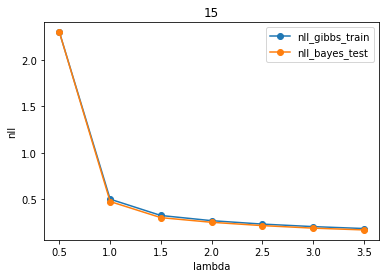

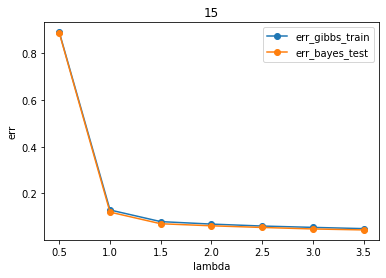

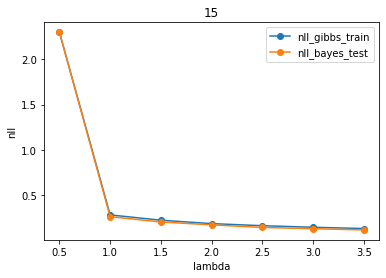

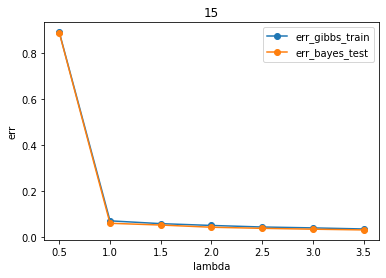

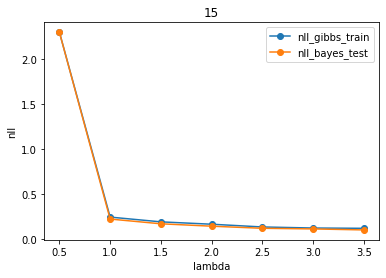

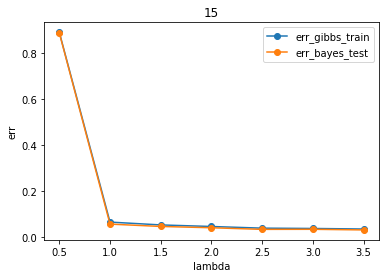

In [12]:
all_metrics_softmax = {}
for gamma in [1.0, 5.0, 10.0]:
    setting_i = f"{dir}/prior_scale_0.01_label_noise_0.0_smooth_softmax_{gamma}_data_augmentation_False"

    with open(f"{setting_i}.pickle", "rb") as handle:
        results = pickle.load(handle)
    metrics = get_metrics(results)
    seeds = list(results.keys())
    cpe_weights = list(results[seeds[0]].keys())
    # cpe_weights.remove("setting")

    all_metrics_softmax[gamma] = metrics

    dir_prefix = f"./main/{setting_i}/"
    if not os.path.exists(dir_prefix):
        os.makedirs(dir_prefix)

    name_metrics = ["nll", "err"]
    for metric in name_metrics:
        for seed in seeds:
            save_name = f"main_{metric}_{seed}"
            plt.title(f"{seed}")
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_gibbs_train"],
                marker="o",
                label=f"{metric}_gibbs_train",
            )
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_bayes_test"],
                marker="o",
                label=f"{metric}_bayes_test",
            )
            # plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
            plt.xticks(np.arange(0, len(cpe_weights), 1), cpe_weights)
            plt.xlabel("lambda")
            plt.ylabel(f"{metric}")
            # plt.ylim(0,0.5)
            plt.legend()
            plt.savefig(f"{dir_prefix}/{save_name}.png", dpi=300)
            plt.show()


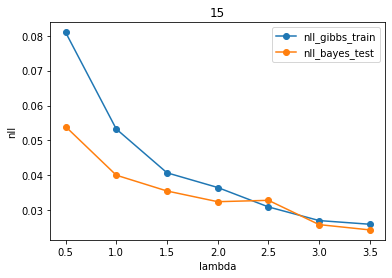

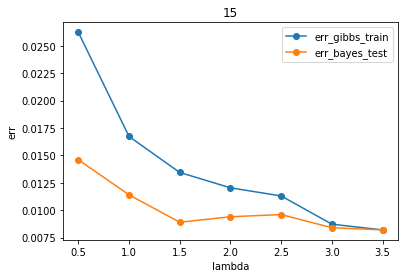

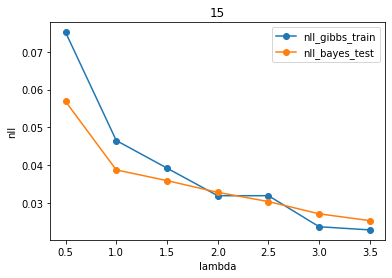

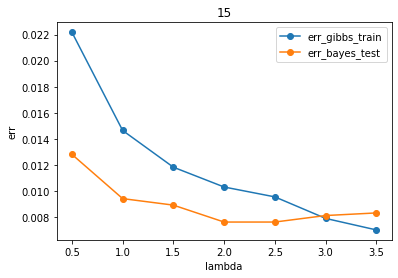

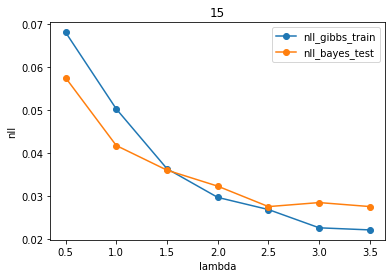

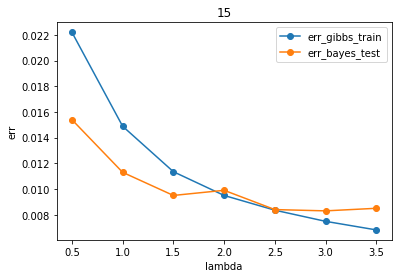

In [13]:
all_metrics_softmax_prior = {}
for gamma in [1.0, 5.0, 10.0]:
    setting_i = f"{dir}/prior_scale_0.1_label_noise_0.0_smooth_softmax_{gamma}_data_augmentation_False"

    with open(f"{setting_i}.pickle", "rb") as handle:
        results = pickle.load(handle)
    metrics = get_metrics(results)
    seeds = list(results.keys())
    cpe_weights = list(results[seeds[0]].keys())
    # cpe_weights.remove("setting")

    all_metrics_softmax_prior[gamma] = metrics

    dir_prefix = f"./main/{setting_i}/"
    if not os.path.exists(dir_prefix):
        os.makedirs(dir_prefix)

    name_metrics = ["nll", "err"]
    for metric in name_metrics:
        for seed in seeds:
            save_name = f"main_{metric}_{seed}"
            plt.title(f"{seed}")
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_gibbs_train"],
                marker="o",
                label=f"{metric}_gibbs_train",
            )
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_bayes_test"],
                marker="o",
                label=f"{metric}_bayes_test",
            )
            # plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
            plt.xticks(np.arange(0, len(cpe_weights), 1), cpe_weights)
            plt.xlabel("lambda")
            plt.ylabel(f"{metric}")
            # plt.ylim(0,0.5)
            plt.legend()
            plt.savefig(f"{dir_prefix}/{save_name}.png", dpi=300)
            plt.show()


In [14]:
name_metric = "nll_bayes_test"
name_seed = 15
df = pd.DataFrame()
for gamma in [1.0, 5.0, 10.0]:
    this_df = pd.DataFrame.from_dict(all_metrics_softmax[gamma][name_seed])[name_metric]
    this_df.rename(gamma, inplace=True)
    df = pd.concat([df, this_df], axis=1)
df.index = list(np.linspace(0.5, 3.5, 7))


In [15]:
df


,1.0,5.0,10.0
0.5,2.301839,2.301401,2.302092
1.0,0.472233,0.258012,0.222602
1.5,0.298221,0.199211,0.169835
2.0,0.247979,0.167253,0.143146
2.5,0.212168,0.138425,0.119802
3.0,0.184917,0.124440,0.112811
3.5,0.165641,0.111231,0.101684



# Joint Plots - Softmax


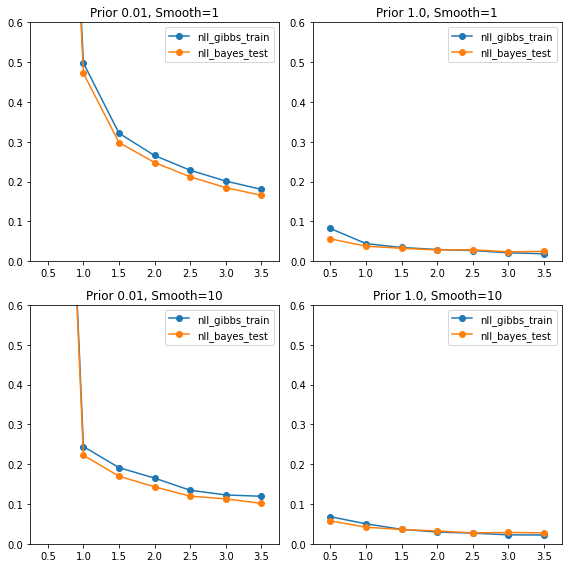

In [17]:
import matplotlib.pyplot as plt
import numpy as np

seed=15
train_loss = "nll_gibbs_train"
test_loss = "nll_bayes_test"
test_loss_g = "nll_gibbs_test"

y_lim=[0,0.6]
x_lim=[0.25,3.75]
# generate some random data
x = np.linspace(0, 2*np.pi, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)
y4 = np.exp(x)

# create a 2x2 grid of subplots with larger subplots and spacing
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

prior=0.01

# plot the data on each subplot and set the limits
axs[0, 0].plot(cpe_weights, all_metrics_priors[prior][seed][train_loss], marker="o", label=train_loss)
axs[0, 0].plot(cpe_weights, all_metrics_priors[prior][seed][test_loss], marker="o", label=test_loss)
#axs[0, 0].plot(cpe_weights, all_metrics_priors[prior][seed][test_loss_g], marker="o", label=test_loss_g)
axs[0, 0].set_xlim(x_lim)
axs[0, 0].set_ylim(y_lim)
axs[0, 0].set_title("Prior 0.01, Smooth=1")
axs[0, 0].legend()


prior=1.0
axs[0, 1].plot(cpe_weights, all_metrics_priors[prior][seed][train_loss], marker="o", label=train_loss)
axs[0, 1].plot(cpe_weights, all_metrics_priors[prior][seed][test_loss], marker="o", label=test_loss)
#axs[0, 1].plot(cpe_weights, all_metrics_priors[prior][seed][test_loss_g], marker="o", label=test_loss_g)
axs[0, 1].set_xlim(x_lim)
axs[0, 1].set_ylim(y_lim)
axs[0, 1].set_title("Prior 1.0, Smooth=1")
axs[0, 1].legend()



gamma=10.0
axs[1, 0].plot(cpe_weights, all_metrics_softmax[gamma][seed][train_loss], marker="o", label=train_loss)
axs[1, 0].plot(cpe_weights, all_metrics_softmax[gamma][seed][test_loss], marker="o", label=test_loss)
#axs[1, 0].plot(cpe_weights, all_metrics_softmax[gamma][seed][test_loss_g], marker="o", label=test_loss_g)
axs[1, 0].set_xlim(x_lim)
axs[1, 0].set_ylim(y_lim)
axs[1, 0].set_title("Prior 0.01, Smooth=10")
axs[1, 0].legend()


gamma=10.0
axs[1, 1].plot(cpe_weights, all_metrics_softmax_prior[gamma][seed][train_loss], marker="o", label=train_loss)
axs[1, 1].plot(cpe_weights, all_metrics_softmax_prior[gamma][seed][test_loss], marker="o", label=test_loss)
#axs[1, 1].plot(cpe_weights, all_metrics_softmax_prior[gamma][seed][test_loss_g], marker="o", label=test_loss_g)
axs[1, 1].set_xlim(x_lim)
axs[1, 1].set_ylim(y_lim)
axs[1, 1].set_title("Prior 1.0, Smooth=10")
axs[1, 1].legend()



# adjust the spacing between subplots
fig.tight_layout()

plt.savefig("cold-posterior-images/biglenet-jointplots-model-misspecification.pdf", format = "pdf",bbox_inches='tight') 

# show the plot
plt.show()


# Joint Plots Data Augmentation

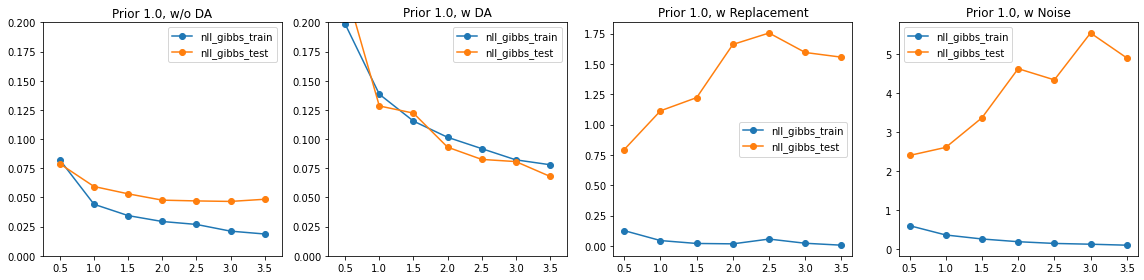

In [18]:
import matplotlib.pyplot as plt
import numpy as np

prior=1.0

seed=15
train_loss = "nll_gibbs_train"
test_loss = "nll_gibbs_test"
y_lim=[0,0.2]
x_lim=[0.25,3.75]
# generate some random data
x = np.linspace(0, 2*np.pi, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)
y4 = np.exp(x)

# create a 2x2 grid of subplots with larger subplots and spacing
fig, axs = plt.subplots(1, 4, figsize=(16, 4))


# plot the data on each subplot and set the limits
axs[0].plot(cpe_weights, all_metrics_priors[prior][seed][train_loss], marker="o", label=train_loss)
axs[0].plot(cpe_weights, all_metrics_priors[prior][seed][test_loss], marker="o", label=test_loss)
axs[0].set_xlim(x_lim)
axs[0].set_ylim(y_lim)
axs[0].set_title(f"Prior {prior}, w/o DA")
axs[0].legend()


axs[1].plot(cpe_weights, all_metrics_priors_aug[prior][seed][train_loss], marker="o", label=train_loss)
axs[1].plot(cpe_weights, all_metrics_priors_aug[prior][seed][test_loss], marker="o", label=test_loss)
axs[1].set_xlim(x_lim)
axs[1].set_ylim(y_lim)
axs[1].set_title(f"Prior {prior}, w DA")
axs[1].legend()


setting_i = f"{dir}/prior_scale_{prior_scale}_label_noise_0.0_smooth_softmax_1.0_data_augmentation_Replacement"

with open(f"{setting_i}.pickle", "rb") as handle:
  results = pickle.load(handle)
metrics = get_metrics(results)


axs[2].plot(cpe_weights, metrics[seed][train_loss], marker="o", label=train_loss)
axs[2].plot(cpe_weights, metrics[seed][test_loss], marker="o", label=test_loss)
#axs[2].set_xlim(x_lim)
#axs[2].set_ylim(y_lim)
axs[2].set_title(f"Prior {prior}, w Replacement")
axs[2].legend()


setting_i = f"{dir}/prior_scale_{prior_scale}_label_noise_0.0_smooth_softmax_1.0_data_augmentation_Noise"

with open(f"{setting_i}.pickle", "rb") as handle:
  results = pickle.load(handle)
metrics = get_metrics(results)


axs[3].plot(cpe_weights, metrics[seed][train_loss], marker="o", label=train_loss)
axs[3].plot(cpe_weights, metrics[seed][test_loss], marker="o", label=test_loss)
#axs[3].set_xlim(x_lim)
#axs[3].set_ylim(y_lim)
axs[3].set_title(f"Prior {prior}, w Noise")
axs[3].legend()


# adjust the spacing between subplots
fig.tight_layout()

plt.savefig("cold-posterior-images/biglenet-jointplots-data-augmentation-gibbs.pdf", format = "pdf",bbox_inches='tight') 

# show the plot
plt.show()


# MLP Plots 

In [36]:
dir='./cold-posteriors-and-pacbayes/results/bnn_classification_mfvi/results_MLP_batchsize_100_epoch_10000_lr_0_0001'

In [38]:
all_metrics_priors = {}
for prior_scale in [0.01, 1.0]:
    setting_i = f"{dir}/prior_scale_{prior_scale}_label_noise_0.0_smooth_softmax_1.0_data_augmentation_None_MLP_100"

    with open(f"{setting_i}.pickle", "rb") as handle:
        results = pickle.load(handle)
    metrics = get_metrics(results)
    seeds = list(results.keys())
    cpe_weights = list(results[seeds[0]].keys())
    # cpe_weights.remove("setting")

    all_metrics_priors[prior_scale] = metrics

all_metrics_softmax = {}
for gamma in [1.0, 10.0]:
    setting_i = f"{dir}/prior_scale_1.0_label_noise_0.0_smooth_softmax_{gamma}_data_augmentation_None_MLP_100"

    with open(f"{setting_i}.pickle", "rb") as handle:
        results = pickle.load(handle)
    metrics = get_metrics(results)
    seeds = list(results.keys())
    cpe_weights = list(results[seeds[0]].keys())
    # cpe_weights.remove("setting")

    all_metrics_softmax[gamma] = metrics

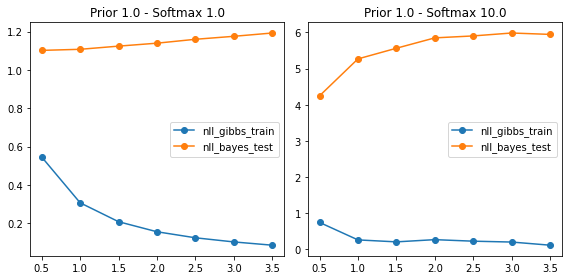

In [39]:
import matplotlib.pyplot as plt
import numpy as np

prior=1.0

seed=15
train_loss = "nll_gibbs_train"
test_loss = "nll_bayes_test"
y_lim=[0,0.2]
x_lim=[0.25,3.75]

# create a 2x2 grid of subplots with larger subplots and spacing
fig, axs = plt.subplots(1, 2, figsize=(8, 4))


prior=1.0
gamma=1.0
# plot the data on each subplot and set the limits
axs[0].plot(cpe_weights, all_metrics_softmax[gamma][seed][train_loss], marker="o", label=train_loss)
axs[0].plot(cpe_weights, all_metrics_softmax[gamma][seed][test_loss], marker="o", label=test_loss)
#axs[0].set_xlim(x_lim)
#axs[0].set_ylim(y_lim)
axs[0].set_title(f"Prior {prior} - Softmax {gamma}")
axs[0].legend()


gamma=10.0
# plot the data on each subplot and set the limits
axs[1].plot(cpe_weights, all_metrics_softmax[gamma][seed][train_loss], marker="o", label=train_loss)
axs[1].plot(cpe_weights, all_metrics_softmax[gamma][seed][test_loss], marker="o", label=test_loss)
#axs[1].set_xlim(x_lim)
#axs[1].set_ylim(y_lim)
axs[1].set_title(f"Prior {prior} - Softmax {gamma}")
axs[1].legend()




# adjust the spacing between subplots
fig.tight_layout()

# show the plot
plt.show()


# Exploring Data Augmentation

In [19]:
seed=15
prior=1.0
lamb=1.0
da=True
setting_i = f"{dir}/prior_scale_{prior}_label_noise_0.0_smooth_softmax_1.0_data_augmentation_{da}"

with open(f"{setting_i}.pickle", "rb") as handle:
  results = pickle.load(handle)


print(results[seed][lamb][0].shape)

log_p_train = np.sum(results[seed][lamb][0],axis=0)
log_p_test = results[seed][lamb][1]
prob_test = np.exp(log_p_test)

log_p_train = np.tile(log_p_train, (prob_test.shape[0], 1))
cov = np.mean(log_p_train*prob_test,axis=1) - np.mean(log_p_train,axis=1)*np.mean(prob_test,axis=1)
prob_mean = np.mean(prob_test,axis=1)
cov_mean = np.mean(cov/prob_mean)

#plt.boxplot(results[seed][lamb][0]);
np.min(cov)

(60000, 10)


-173.43262

## Gradient Bayes Loss

In [20]:
def gradientBayesLoss(seed, prior, lamb, gamma, da):

  setting_i = f"{dir}/prior_scale_{prior}_label_noise_0.0_smooth_softmax_{gamma}_data_augmentation_{da}"

  with open(f"{setting_i}.pickle", "rb") as handle:
    results = pickle.load(handle)


  log_p_train = np.sum(results[seed][lamb][0],axis=0)
  log_p_test = results[seed][lamb][1]
  prob_test = np.exp(log_p_test)

  log_p_train = np.tile(log_p_train, (prob_test.shape[0], 1))

  cov = np.mean(log_p_train*prob_test,axis=1) - np.mean(log_p_train,axis=1)*np.mean(prob_test,axis=1)
  prob_mean = np.mean(prob_test,axis=1)
  cov_mean = np.mean(cov/prob_mean)
  return -cov_mean, -cov, prob_mean

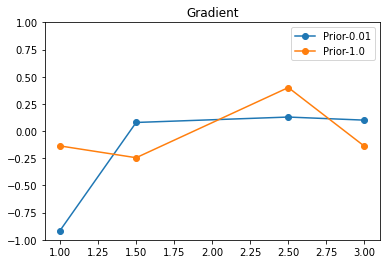

In [21]:
seed=15
lambdas = [1.0, 1.5, 2.5, 3.0]
da=False
vals = [gradientBayesLoss(seed, 0.01, lamb, 1.0, da)[0] for lamb in lambdas]
plt.plot(lambdas,vals, marker="o", label="Prior-0.01")
vals = [gradientBayesLoss(seed, 1.0, lamb, 1.0, da)[0] for lamb in lambdas]
plt.plot(lambdas,vals, marker="o", label="Prior-1.0")
plt.ylim(-1,1)
plt.title("Gradient")
plt.legend()

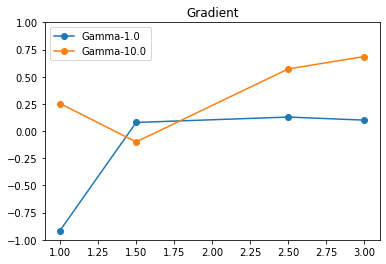

In [22]:
seed=15
da=False
vals = [gradientBayesLoss(seed, 0.01, lamb, 1.0, da)[0] for lamb in lambdas]
plt.plot(lambdas,vals, marker="o", label="Gamma-1.0")
vals = [gradientBayesLoss(seed, 0.01, lamb, 10.0, da)[0] for lamb in lambdas]
plt.plot(lambdas,vals, marker="o", label="Gamma-10.0")
plt.ylim(-1,1)
plt.title("Gradient")
plt.legend()

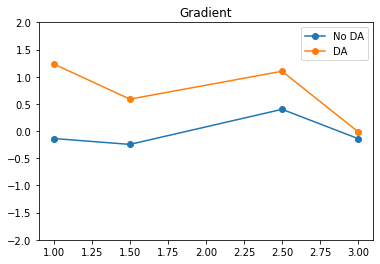

In [23]:
seed=15
prior=1.0
lambdas = [1.0, 1.5, 2.5, 3.0]
vals = [gradientBayesLoss(seed, 1.0, lamb, 1.0, False)[0] for lamb in lambdas]
plt.plot(lambdas,vals, marker="o", label="No DA")
vals = [gradientBayesLoss(seed, 1.0, lamb, 1.0, True)[0] for lamb in lambdas]
plt.plot(lambdas,vals, marker="o", label="DA")
plt.ylim(-2,2)
plt.title("Gradient")
plt.legend()

## Gradient Gibbs Loss

In [24]:
def gradientGibbsLoss(seed, prior=1.0, lamb=1.0, gamma=1.0, da=False):

  setting_i = f"{dir}/prior_scale_{prior}_label_noise_0.0_smooth_softmax_{gamma}_data_augmentation_{da}"

  with open(f"{setting_i}.pickle", "rb") as handle:
    results = pickle.load(handle)


  log_p_train = np.sum(results[seed][lamb][0],axis=0)
  log_p_test = -np.mean(results[seed][lamb][1],axis=0)

  cov = np.mean(log_p_train*log_p_test,axis=0) - np.mean(log_p_train,axis=0)*np.mean(log_p_test,axis=0)
  return np.cov(log_p_train,log_p_test)[0, 1]

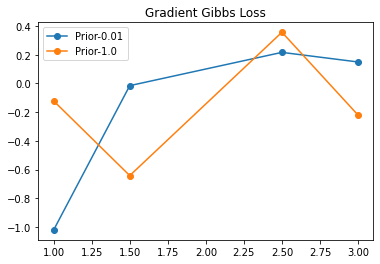

In [25]:
seed=15
lambdas = [1.0, 1.5, 2.5, 3.0]
vals = [gradientGibbsLoss(seed, prior=0.01, lamb=lamb, gamma=1.0, da=False) for lamb in lambdas]
plt.plot(lambdas,vals, marker="o", label="Prior-0.01")
vals = [gradientGibbsLoss(seed, prior=1.0, lamb=lamb, gamma=1.0, da=False) for lamb in lambdas]
plt.plot(lambdas,vals, marker="o", label="Prior-1.0")
plt.title("Gradient Gibbs Loss")
plt.legend()

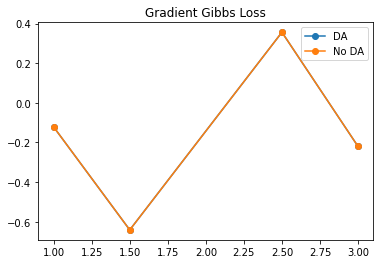

In [27]:
seed=15
prior=1.0
da=True
lambdas = [1.0, 1.5, 2.5, 3.0]
#vals = [gradientGibbsLoss(seed, prior, lamb, da) for lamb in lambdas]
plt.plot(lambdas,vals, marker="o", label="DA")
da=False
#vals = [gradientGibbsLoss(seed, prior, lamb, da) for lamb in lambdas]
plt.plot(lambdas,vals, marker="o", label="No DA")
plt.title("Gradient Gibbs Loss")
plt.legend()

## Scatter Plots

In [28]:
def scatterGibbs(seed, prior=1.0, lamb=1.0, gamma=1.0, da=False):

  setting_i = f"{dir}/prior_scale_{prior}_label_noise_0.0_smooth_softmax_{gamma}_data_augmentation_{da}"

  with open(f"{setting_i}.pickle", "rb") as handle:
    results = pickle.load(handle)


  log_p_train = -np.sum(results[seed][lamb][0],axis=0)
  log_p_test = -np.mean(results[seed][lamb][1],axis=0)

  plt.scatter(log_p_train,log_p_test)

  return np.cov(log_p_train,log_p_test)[0, 1], np.corrcoef(log_p_train,log_p_test)[0, 1]

(-1.6361919913135452, -0.22521563102734848)

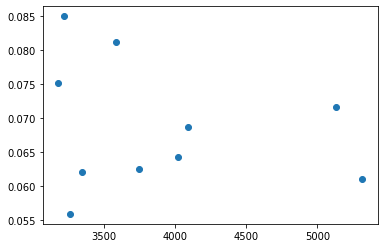

In [29]:
scatterGibbs(seed, prior=1.0, lamb=1.0, gamma=10.0, da=False)

# Download results

In [ ]:
!tar -cvf myfiles.tar *.pickle

In [ ]:
from google.colab import files
files.download('results.zip')

In [ ]:
!git clone https://github.com/pyijiezhang/cold-posteriors-and-pacbayes

In [ ]:
files.download("cold-posterior-images/biglenet-jointplots-model-misspecification-gibbs.pdf")